In [77]:
%pip install dask[complete]
%pip install pyarrow
%pip install pandas


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [78]:
import dask.dataframe as dd

# Path to your CSV
csv_path = 'US_Accidents_March23_sampled_500k.csv'

# Read the dataset in chunks
df = dd.read_csv(csv_path, dtype={
    'Severity': 'int8', 
    'Temperature(F)': 'float32', 
    'Wind_Speed(mph)': 'float32',
    'Humidity(%)': 'float32',
    'Precipitation(in)': 'float32',
    'Weather_Condition': 'object',
    'Description': 'object',
    'City': 'object',
    'State': 'object',
    'Timezone': 'object'
})

# Calculate the fraction to sample 250000 rows
# We estimate the fraction needed based on the dataset size
total_rows = df.shape[0].compute()  # Compute total rows in the dataset (after loading chunks)
frac_to_sample = 250001 / total_rows

# Sample 5 million rows from the dataset
sampled_df = df.sample(frac=frac_to_sample, random_state=42)

# Compute the sampled data into a pandas DataFrame (this will trigger the sampling and load it into memory)
sampled_df = sampled_df.compute()

# Convert to Dask DataFrame again for further processing (if needed)
sampled_ddf = dd.from_pandas(sampled_df, npartitions=4)

# Display the first few rows to verify
print(sampled_ddf.head())

# Get the shape of the dataset
num_rows = len(sampled_ddf)
num_columns = len(sampled_ddf.columns)
print(f"Shape of the sampled dataset: ({num_rows}, {num_columns})")

          ID   Source  Severity                     Start_Time  \
0  A-7383624  Source1         2            2019-11-21 07:31:11   
0  A-2973059  Source2         2            2018-03-28 22:55:23   
1  A-5968163  Source1         2            2021-11-16 09:26:48   
1  A-4694324  Source1         2  2022-12-03 23:37:14.000000000   
2  A-5006183  Source1         2  2022-08-20 13:13:00.000000000   

                        End_Time  Start_Lat   Start_Lng    End_Lat  \
0            2019-11-21 11:31:11  42.405430 -123.441390  42.405430   
0            2018-03-28 23:55:12  35.350765  -80.717972        NaN   
1            2021-11-16 14:11:51  39.692198  -77.733926  39.720798   
1  2022-12-04 01:56:53.000000000  38.990562  -77.399070  38.990037   
2  2022-08-20 15:22:45.000000000  34.661189 -120.492822  34.661189   

      End_Lng  Distance(mi)  ... Roundabout Station   Stop Traffic_Calming  \
0 -123.441390         0.000  ...      False   False  False           False   
0         NaN         0.00

# Preprocessings

In [79]:
# Get the number of rows and columns by computing the shape
num_rows = sampled_ddf.shape[0].compute()  # Compute the number of rows
num_columns = sampled_ddf.shape[1]  # The number of columns can be directly accessed

print(f"Shape of the dataset: ({num_rows}, {num_columns})")


Shape of the dataset: (250001, 46)


In [80]:
# Count the occurrences of each unique value in the 'Source' column
source_counts = sampled_ddf['Source'].value_counts().compute()

# Display the counts of each source
print("Count of each value in the 'Source' column:\n", source_counts)


Count of each value in the 'Source' column:
 Source
Source1    140082
Source3      3105
Source2    106814
Name: count, dtype: int64[pyarrow]


In [81]:
# Filter the rows where the 'Source' column is 'Source1'
source1_data = sampled_ddf[sampled_ddf['Source'] == 'Source1']

# Compute the filtered data (bring it into memory if needed)
source1_data_computed = source1_data.compute()

# Display the first few rows of the filtered data
print(source1_data_computed.head())

# Optional: Get the shape of the filtered data
print(f"Shape of the filtered dataset (Source1): ({len(source1_data_computed)}, {len(source1_data_computed.columns)})")


          ID   Source  Severity                     Start_Time  \
0  A-7383624  Source1         2            2019-11-21 07:31:11   
1  A-5968163  Source1         2            2021-11-16 09:26:48   
1  A-4694324  Source1         2  2022-12-03 23:37:14.000000000   
2  A-5006183  Source1         2  2022-08-20 13:13:00.000000000   
3  A-4237356  Source1         2            2022-02-21 17:43:04   

                        End_Time  Start_Lat   Start_Lng    End_Lat  \
0            2019-11-21 11:31:11  42.405430 -123.441390  42.405430   
1            2021-11-16 14:11:51  39.692198  -77.733926  39.720798   
1  2022-12-04 01:56:53.000000000  38.990562  -77.399070  38.990037   
2  2022-08-20 15:22:45.000000000  34.661189 -120.492822  34.661189   
3            2022-02-21 19:43:23  43.680592  -92.993317  43.680574   

      End_Lng  Distance(mi)  ... Roundabout Station   Stop Traffic_Calming  \
0 -123.441390         0.000  ...      False   False  False           False   
1  -77.732846         1.97

In [82]:
# Count the occurrences of each unique value in the 'Source' column
source_counts = source1_data['Source'].value_counts().compute()

# Display the counts of each source
print("Count of each value in the 'Source' column:\n", source_counts)


Count of each value in the 'Source' column:
 Source
Source1    140082
Name: count, dtype: int64[pyarrow]


In [83]:
# Get the number of rows and columns by computing the shape
num_rows = source1_data.shape[0].compute()  # Compute the number of rows
num_columns = source1_data.shape[1]  # The number of columns can be directly accessed

print(f"Shape of the dataset: ({num_rows}, {num_columns})")

Shape of the dataset: (140082, 46)


In [84]:
# Check for missing values in the dataset
missing_data = source1_data.isnull().sum().compute()
print("Missing data per column:\n", missing_data)

Missing data per column:
 ID                           0
Source                       0
Severity                     0
Start_Time                   0
End_Time                     0
Start_Lat                    0
Start_Lng                    0
End_Lat                      0
End_Lng                      0
Distance(mi)                 0
Description                  0
Street                     295
City                        10
County                       0
State                        0
Zipcode                     38
Country                      0
Timezone                   137
Airport_Code               493
Weather_Timestamp         2473
Temperature(F)            3320
Wind_Chill(F)            17154
Humidity(%)               3532
Pressure(in)              2843
Visibility(mi)            3487
Wind_Direction            3743
Wind_Speed(mph)           6483
Precipitation(in)        20099
Weather_Condition         3434
Amenity                      0
Bump                         0
Crossing     

In [85]:
# Check data types of each column
print("Data types of each column:\n", source1_data.dtypes)

Data types of each column:
 ID                       string[pyarrow]
Source                   string[pyarrow]
Severity                            int8
Start_Time               string[pyarrow]
End_Time                 string[pyarrow]
Start_Lat                        float64
Start_Lng                        float64
End_Lat                          float64
End_Lng                          float64
Distance(mi)                     float64
Description              string[pyarrow]
Street                   string[pyarrow]
City                     string[pyarrow]
County                   string[pyarrow]
State                    string[pyarrow]
Zipcode                  string[pyarrow]
Country                  string[pyarrow]
Timezone                 string[pyarrow]
Airport_Code             string[pyarrow]
Weather_Timestamp        string[pyarrow]
Temperature(F)                   float32
Wind_Chill(F)                    float64
Humidity(%)                      float32
Pressure(in)                 

In [86]:
# Get basic statistics for numerical features
numerical_stats = source1_data.describe().compute()
print("Basic statistics for numerical features:\n", numerical_stats)

Basic statistics for numerical features:
             Severity      Start_Lat      Start_Lng        End_Lat  \
count  140082.000000  140082.000000  140082.000000  140082.000000   
mean        2.118666      36.275301     -95.739283      36.275410   
std         0.452484       5.276292      18.106508       5.276486   
min         1.000000      24.570222    -124.497420      24.570110   
25%         2.000000      33.495294    -117.711973      33.499261   
50%         2.000000      36.264255     -87.926385      36.266621   
75%         2.000000      40.233970     -80.242967      40.236885   
max         4.000000      48.991585     -67.484130      48.998901   

             End_Lng   Distance(mi)  Temperature(F)  Wind_Chill(F)  \
count  140082.000000  140082.000000   136762.000000  122928.000000   
mean      -95.738996       0.836510       61.083371      59.014985   
std        18.106163       1.839406       19.375960      22.043258   
min      -124.497419       0.000000      -35.000000     

In [87]:
# Distribution of categorical variables (e.g., Severity and Weather_Condition)
severity_distribution = source1_data['Severity'].value_counts().compute()
weather_condition_distribution = source1_data['Weather_Condition'].value_counts().compute()

print("Distribution of Accident Severity:\n", severity_distribution)
print("Distribution of Weather Conditions:\n", weather_condition_distribution)


Distribution of Accident Severity:
 Severity
1       901
2    127771
3      5296
4      6114
Name: count, dtype: int64
Distribution of Weather Conditions:
 Weather_Condition
Cloudy                     17955
Drizzle and Fog                7
Fog                         1996
Heavy Snow                   136
Heavy Snow / Windy            27
                           ...  
Snow                         366
Thunder                      351
Thunder / Windy               15
Thunder in the Vicinity      432
Widespread Dust                4
Name: count, Length: 87, dtype: int64[pyarrow]


In [88]:
# Check the data types
print(source1_data.dtypes)

# Check for missing values
missing_data = source1_data.isnull().sum()
print("Missing data per column:\n", missing_data)

# Get basic statistics
print(source1_data.describe())

# Check the distribution of categorical variables
print(source1_data['Severity'].value_counts())
print(source1_data['Weather_Condition'].value_counts())

ID                       string[pyarrow]
Source                   string[pyarrow]
Severity                            int8
Start_Time               string[pyarrow]
End_Time                 string[pyarrow]
Start_Lat                        float64
Start_Lng                        float64
End_Lat                          float64
End_Lng                          float64
Distance(mi)                     float64
Description              string[pyarrow]
Street                   string[pyarrow]
City                     string[pyarrow]
County                   string[pyarrow]
State                    string[pyarrow]
Zipcode                  string[pyarrow]
Country                  string[pyarrow]
Timezone                 string[pyarrow]
Airport_Code             string[pyarrow]
Weather_Timestamp        string[pyarrow]
Temperature(F)                   float32
Wind_Chill(F)                    float64
Humidity(%)                      float32
Pressure(in)                     float64
Visibility(mi)  

In [89]:
import pandas as pd

# Calculate the percentage of missing values for each feature
missing_percentage = (source1_data.isnull().sum() / len(source1_data)) * 100

# Create a DataFrame to display the missing percentage for each feature
missing_values_table = pd.DataFrame({
    'Feature': source1_data.columns,
    'Missing Percentage': missing_percentage
})

# Sort the table by Missing Percentage in descending order for better visualization
missing_values_table = missing_values_table.sort_values(by='Missing Percentage', ascending=False)

# Display the table
print(missing_values_table)


                  Feature  Missing Percentage
27      Precipitation(in)           14.348025
21          Wind_Chill(F)           12.245685
26        Wind_Speed(mph)            4.628004
25         Wind_Direction            2.672006
22            Humidity(%)            2.521380
24         Visibility(mi)            2.489256
28      Weather_Condition            2.451421
20         Temperature(F)            2.370040
23           Pressure(in)            2.029526
19      Weather_Timestamp            1.765395
44      Nautical_Twilight            0.486144
43         Civil_Twilight            0.486144
42         Sunrise_Sunset            0.486144
45  Astronomical_Twilight            0.486144
18           Airport_Code            0.351937
11                 Street            0.210591
17               Timezone            0.097800
15                Zipcode            0.027127
12                   City            0.007139
14                  State            0.000000
39        Traffic_Calming         

In [90]:
# Drop the specified columns
columns_to_drop = ['ID', 'Description', 'Distance(mi)', 'End_Time', 'End_Lat', 'End_Lng']

# Drop columns from the filtered dataset
source1_data_dropped = source1_data_computed.drop(columns=columns_to_drop)

# Optional: Get the shape of the cleaned dataset
print(f"Shape of the filtered and cleaned dataset (Source1): ({len(source1_data_dropped)}, {len(source1_data_dropped.columns)})")


Shape of the filtered and cleaned dataset (Source1): (140082, 40)


In [91]:
# List of categorical features
categorical_features = [
    'Country', 'Timezone', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 
    'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 
    'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 
    'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Source'
]

# Get the unique counts of each categorical feature
unique_counts = source1_data_dropped[categorical_features].nunique()

# Display the unique counts
print("Unique counts of categorical features:\n", unique_counts)


Unique counts of categorical features:
 Country                  1
Timezone                 4
Amenity                  2
Bump                     2
Crossing                 2
Give_Way                 2
Junction                 2
No_Exit                  2
Railway                  2
Roundabout               2
Station                  2
Stop                     2
Traffic_Calming          2
Traffic_Signal           2
Turning_Loop             1
Sunrise_Sunset           2
Civil_Twilight           2
Nautical_Twilight        2
Astronomical_Twilight    2
Source                   1
dtype: int64


In [92]:
# Drop the specified columns
columns_to_drop = ['Country', 'Turning_Loop', 'Source']

# Drop columns from the filtered dataset
source1_data_dropped = source1_data_dropped.drop(columns=columns_to_drop)

# Optional: Get the shape of the cleaned dataset
print(f"Shape of the filtered and cleaned dataset (Source1): ({len(source1_data_dropped)}, {len(source1_data_dropped.columns)})")


Shape of the filtered and cleaned dataset (Source1): (140082, 37)


In [93]:
# Print unique values in the 'Wind_Direction' column before preprocessing
print("Wind Direction before simplification: ", source1_data_dropped['Wind_Direction'].unique())

Wind Direction before simplification:  <ArrowStringArray>
[     'ESE',        'W',      'ENE',      'WSW',        'E',      'VAR',
      'NNW',        'S',       'NW',      'WNW',       'SE',      'SSE',
       <NA>,     'CALM',       'NE',      'SSW',     'Calm',       'SW',
      'NNE',        'N',     'West',    'North', 'Variable',     'East',
    'South']
Length: 25, dtype: string


In [94]:
# Preprocess the 'Wind_Direction' column
source1_data_dropped.loc[source1_data_dropped['Wind_Direction'] == 'Calm', 'Wind_Direction'] = 'CALM'
source1_data_dropped.loc[source1_data_dropped['Wind_Direction'].isin(['West', 'WSW', 'WNW']), 'Wind_Direction'] = 'W'
source1_data_dropped.loc[source1_data_dropped['Wind_Direction'].isin(['South', 'SSW', 'SSE']), 'Wind_Direction'] = 'S'
source1_data_dropped.loc[source1_data_dropped['Wind_Direction'].isin(['North', 'NNW', 'NNE']), 'Wind_Direction'] = 'N'
source1_data_dropped.loc[source1_data_dropped['Wind_Direction'].isin(['East', 'ESE', 'ENE']), 'Wind_Direction'] = 'E'
source1_data_dropped.loc[source1_data_dropped['Wind_Direction'] == 'Variable', 'Wind_Direction'] = 'VAR'

# Print unique values in the 'Wind_Direction' column after preprocessing
print("Wind Direction after simplification: ", source1_data_dropped['Wind_Direction'].unique())


Wind Direction after simplification:  <ArrowStringArray>
[       'E',        'W',      'VAR',        'N',        'S',       'NW',
       'SE',       <NA>,     'CALM',       'NE',       'SW',     'Calm',
 'Variable']
Length: 13, dtype: string


In [95]:
import numpy as np
import re

# Show distinctive weather conditions and clean them
weather = '!'.join(source1_data_dropped['Weather_Condition'].dropna().unique().tolist())
weather = np.unique(np.array(re.split(
    "!|\s/\s|\sand\s|\swith\s|Partly\s|Mostly\s|Blowing\s|Freezing\s", weather))).tolist()
print("Weather Conditions: ", weather)

Weather Conditions:  ['', 'Clear', 'Cloudy', 'Drizzle', 'Dust', 'Fair', 'Fog', 'Hail', 'Haze', 'Heavy Drizzle', 'Heavy Rain', 'Heavy Sleet', 'Heavy Snow', 'Heavy T-Storm', 'Heavy Thunderstorms', 'Ice Pellets', 'Light ', 'Light Drizzle', 'Light Ice Pellets', 'Light Rain', 'Light Rain Shower', 'Light Rain Showers', 'Light Sleet', 'Light Snow', 'Light Snow Shower', 'Light Thunderstorms', 'Mist', 'N/A Precipitation', 'Overcast', 'Partial Fog', 'Patches of Fog', 'Rain', 'Rain Showers', 'Scattered Clouds', 'Shallow Fog', 'Showers in the Vicinity', 'Sleet', 'Small Hail', 'Smoke', 'Snow', 'T-Storm', 'Thunder', 'Thunder in the Vicinity', 'Thunderstorm', 'Thunderstorms', 'Tornado', 'Widespread Dust', 'Windy', 'Wintry Mix']


In [96]:
# Create new weather-related columns based on keywords
source1_data_dropped['Clear'] = np.where(source1_data_dropped['Weather_Condition'].str.contains('Clear', case=False, na=False), True, False)
source1_data_dropped['Cloud'] = np.where(source1_data_dropped['Weather_Condition'].str.contains('Cloud|Overcast', case=False, na=False), True, False)
source1_data_dropped['Rain'] = np.where(source1_data_dropped['Weather_Condition'].str.contains('Rain|storm', case=False, na=False), True, False)
source1_data_dropped['Heavy_Rain'] = np.where(source1_data_dropped['Weather_Condition'].str.contains('Heavy Rain|Rain Shower|Heavy T-Storm|Heavy Thunderstorms', case=False, na=False), True, False)
source1_data_dropped['Snow'] = np.where(source1_data_dropped['Weather_Condition'].str.contains('Snow|Sleet|Ice', case=False, na=False), True, False)
source1_data_dropped['Heavy_Snow'] = np.where(source1_data_dropped['Weather_Condition'].str.contains('Heavy Snow|Heavy Sleet|Heavy Ice Pellets|Snow Showers|Squalls', case=False, na=False), True, False)
source1_data_dropped['Fog'] = np.where(source1_data_dropped['Weather_Condition'].str.contains('Fog', case=False, na=False), True, False)

# Assign NA to created weather features where 'Weather_Condition' is null
weather_columns = ['Clear','Cloud','Rain','Heavy_Rain','Snow','Heavy_Snow','Fog']
for column in weather_columns:
    source1_data_dropped.loc[source1_data_dropped['Weather_Condition'].isnull(), column] = False
    source1_data_dropped[column] = source1_data_dropped[column].astype('bool')

# Optionally display the newly created weather columns
print(source1_data_dropped[['Weather_Condition'] + weather_columns].head())

# Drop the original 'Weather_Condition' column
source1_data_dropped = source1_data_dropped.drop(['Weather_Condition'], axis=1)

  Weather_Condition  Clear  Cloud   Rain  Heavy_Rain   Snow  Heavy_Snow    Fog
0              Fair  False  False  False       False  False       False  False
1     Partly Cloudy  False   True  False       False  False       False  False
1              Fair  False  False  False       False  False       False  False
2              Fair  False  False  False       False  False       False  False
3        Wintry Mix  False  False  False       False  False       False  False


In [97]:
# Optional: Get the shape of the cleaned dataset
print(f"Shape of the filtered and cleaned dataset (Source1): ({len(source1_data_dropped)}, {len(source1_data_dropped.columns)})")


Shape of the filtered and cleaned dataset (Source1): (140082, 43)


In [98]:
import dask.dataframe as dd

# Ensure that source1_data_dropped is a Dask DataFrame. If not, convert it to Dask.
# If source1_data_dropped is already a Dask DataFrame, skip this part
if not isinstance(source1_data_dropped, dd.DataFrame):
    source1_data_dropped = dd.from_pandas(source1_data_dropped, npartitions=4)

# Convert 'Start_Time' to datetime format using Dask's to_datetime (this is a lazy operation)
source1_data_dropped['Start_Time'] = dd.to_datetime(source1_data_dropped['Start_Time'], errors='coerce')

# Convert 'Weather_Timestamp' to datetime format using Dask's to_datetime (this is a lazy operation)
source1_data_dropped['Weather_Timestamp'] = dd.to_datetime(source1_data_dropped['Weather_Timestamp'], errors='coerce')

# Now compute the changes and convert the result into a pandas DataFrame
source1_data_dropped_computed = source1_data_dropped.compute()

# Display the first few rows to verify the conversion
print(source1_data_dropped_computed[['Start_Time', 'Weather_Timestamp']].head())



           Start_Time   Weather_Timestamp
0 2019-11-21 07:31:11 2019-11-21 07:56:00
1 2021-11-16 09:26:48 2021-11-16 09:53:00
1                 NaT 2022-12-03 23:52:00
2                 NaT 2022-08-20 12:56:00
3 2022-02-21 17:43:04 2022-02-21 17:35:00


In [99]:
import pandas as pd

# Compute the DataFrame to bring the results into memory (since Dask is lazy)
source1_data_dropped_computed = source1_data_dropped.compute()

# Generate 'weekend_or_not' column (True for weekends, False for weekdays)
source1_data_dropped_computed['weekend_or_not'] = source1_data_dropped_computed['Weather_Timestamp'].dt.dayofweek >= 5  # Saturday (5) and Sunday (6)

# Generate 'day_or_night' column (True for day, False for night based on time)
source1_data_dropped_computed['day_or_night'] = ((source1_data_dropped_computed['Weather_Timestamp'].dt.hour >= 6) & (source1_data_dropped_computed['Weather_Timestamp'].dt.hour < 18))

# Extract Year
source1_data_dropped_computed['Year'] = source1_data_dropped_computed['Weather_Timestamp'].dt.year

# Extract Month
source1_data_dropped_computed['Month'] = source1_data_dropped_computed['Weather_Timestamp'].dt.month

# Extract Day of Year
source1_data_dropped_computed['Day'] = source1_data_dropped_computed['Weather_Timestamp'].dt.dayofyear

# Extract Weekday (0=Monday)
source1_data_dropped_computed['Weekday'] = source1_data_dropped_computed['Weather_Timestamp'].dt.weekday

# Extract Hour
source1_data_dropped_computed['Hour'] = source1_data_dropped_computed['Weather_Timestamp'].dt.hour

# Extract Minute of Day
source1_data_dropped_computed['Minute'] = source1_data_dropped_computed['Hour'] * 60 + source1_data_dropped_computed['Weather_Timestamp'].dt.minute

# Display the first few rows to verify the new columns
print(source1_data_dropped_computed[['Start_Time', 'weekend_or_not', 'day_or_night', 'Year', 'Month', 'Weekday', 'Day', 'Hour', 'Minute']].head())

# Drop the original 'Start_Time' column
source1_data_dropped_computed = source1_data_dropped_computed.drop(['Start_Time'], axis=1)

           Start_Time  weekend_or_not  day_or_night    Year  Month  Weekday  \
0 2019-11-21 07:31:11           False          True  2019.0   11.0      3.0   
1 2021-11-16 09:26:48           False          True  2021.0   11.0      1.0   
1                 NaT            True         False  2022.0   12.0      5.0   
2                 NaT            True          True  2022.0    8.0      5.0   
3 2022-02-21 17:43:04           False          True  2022.0    2.0      0.0   

     Day  Hour  Minute  
0  325.0   7.0   476.0  
1  320.0   9.0   593.0  
1  337.0  23.0  1432.0  
2  232.0  12.0   776.0  
3   52.0  17.0  1055.0  


In [100]:
# Get the value counts for the 'weekend_or_not' column
weekend_counts = source1_data_dropped_computed['weekend_or_not'].value_counts()

# Display the result
print("Value counts of 'weekend_or_not':\n", weekend_counts)


Value counts of 'weekend_or_not':
 weekend_or_not
False    112419
True      27663
Name: count, dtype: int64


In [101]:
import pandas as pd

# Calculate the percentage of missing values for each feature
missing_percentage = (source1_data_dropped_computed.isnull().sum() / len(source1_data_dropped_computed)) * 100

# Create a DataFrame to display the missing percentage for each feature
missing_values_table = pd.DataFrame({
    'Feature': source1_data_dropped_computed.columns,
    'Missing Percentage': missing_percentage
})

# Sort the table by Missing Percentage in descending order for better visualization
missing_values_table = missing_values_table.sort_values(by='Missing Percentage', ascending=False)

# Display the table
print(missing_values_table)

                                     Feature  Missing Percentage
Precipitation(in)          Precipitation(in)           14.348025
Wind_Chill(F)                  Wind_Chill(F)           12.245685
Wind_Speed(mph)              Wind_Speed(mph)            4.628004
Wind_Direction                Wind_Direction            2.672006
Humidity(%)                      Humidity(%)            2.521380
Visibility(mi)                Visibility(mi)            2.489256
Temperature(F)                Temperature(F)            2.370040
Pressure(in)                    Pressure(in)            2.029526
Year                                    Year            1.765395
Month                                  Month            1.765395
Minute                                Minute            1.765395
Weather_Timestamp          Weather_Timestamp            1.765395
Weekday                              Weekday            1.765395
Day                                      Day            1.765395
Hour                     

In [102]:
# Drop the 'Wind_Chill(F)' column due to significant missing values
source1_data_dropped_computed = source1_data_dropped_computed.drop('Wind_Chill(F)', axis=1)

In [103]:
# List of columns to check for missing values
columns_to_check = ['Nautical_Twilight', 'Civil_Twilight', 'Astronomical_Twilight', 'Sunrise_Sunset', 
                    'Airport_Code', 'Street', 'Timezone', 'Zipcode', 'City', 'Year', 'Month', 'Weekday', 'Day', 'Hour', 'Minute']

# Drop rows where any of the listed columns have missing values
source1_data_dropped_computed_cleaned = source1_data_dropped_computed.dropna(subset=columns_to_check)

# Check the shape of the cleaned dataset
print(f"Shape of the cleaned dataset: ({len(source1_data_dropped_computed_cleaned)}, {len(source1_data_dropped_computed_cleaned.columns)})")


Shape of the cleaned dataset: (136709, 49)


In [104]:
import pandas as pd

# Calculate the percentage of missing values for each feature
missing_percentage = (source1_data_dropped_computed_cleaned.isnull().sum() / len(source1_data_dropped_computed_cleaned)) * 100

# Create a DataFrame to display the missing percentage for each feature
missing_values_table = pd.DataFrame({
    'Feature': source1_data_dropped_computed_cleaned.columns,
    'Missing Percentage': missing_percentage
})

# Sort the table by Missing Percentage in descending order for better visualization
missing_values_table = missing_values_table.sort_values(by='Missing Percentage', ascending=False)

# Display the table
print(missing_values_table)

                                     Feature  Missing Percentage
Precipitation(in)          Precipitation(in)           12.883570
Wind_Speed(mph)              Wind_Speed(mph)            2.925923
Wind_Direction                Wind_Direction            0.922397
Humidity(%)                      Humidity(%)            0.767323
Visibility(mi)                Visibility(mi)            0.732944
Temperature(F)                Temperature(F)            0.612981
Pressure(in)                    Pressure(in)            0.266990
Sunrise_Sunset                Sunrise_Sunset            0.000000
Civil_Twilight                Civil_Twilight            0.000000
Nautical_Twilight          Nautical_Twilight            0.000000
Astronomical_Twilight  Astronomical_Twilight            0.000000
Clear                                  Clear            0.000000
Cloud                                  Cloud            0.000000
Rain                                    Rain            0.000000
Heavy_Rain               

In [105]:
# Apply describe to the 'Precipitation(in)' column
precipitation_stats = source1_data_dropped_computed_cleaned['Precipitation(in)'].describe()

# Display the summary statistics
print("Summary statistics for 'Precipitation(in)':\n", precipitation_stats)

Summary statistics for 'Precipitation(in)':
 count    119096.000000
mean          0.006485
std           0.071762
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.990000
Name: Precipitation(in), dtype: float64


In [106]:
# Calculate the median of 'Precipitation(in)'
median_value = source1_data_dropped_computed_cleaned['Precipitation(in)'].median()

# Impute missing values in 'Precipitation(in)' with the calculated median
source1_data_dropped_computed_cleaned['Precipitation(in)'].fillna(median_value, inplace=True)

# Verify that there are no more missing values in 'Precipitation(in)'
print(f"Missing values in 'Precipitation(in)' after imputation: {source1_data_dropped_computed_cleaned['Precipitation(in)'].isnull().sum()}")


Missing values in 'Precipitation(in)' after imputation: 0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_3640\327441522.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  source1_data_dropped_computed_cleaned['Precipitation(in)'].fillna(median_value, inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_3640\327441522.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source1_data_dropped_computed_c

In [107]:
import pandas as pd

# Calculate the percentage of missing values for each feature
missing_percentage = (source1_data_dropped_computed_cleaned.isnull().sum() / len(source1_data_dropped_computed_cleaned)) * 100

# Create a DataFrame to display the missing percentage for each feature
missing_values_table = pd.DataFrame({
    'Feature': source1_data_dropped_computed_cleaned.columns,
    'Missing Percentage': missing_percentage
})

# Sort the table by Missing Percentage in descending order for better visualization
missing_values_table = missing_values_table.sort_values(by='Missing Percentage', ascending=False)

# Display the table
print(missing_values_table)

                                     Feature  Missing Percentage
Wind_Speed(mph)              Wind_Speed(mph)            2.925923
Wind_Direction                Wind_Direction            0.922397
Humidity(%)                      Humidity(%)            0.767323
Visibility(mi)                Visibility(mi)            0.732944
Temperature(F)                Temperature(F)            0.612981
Pressure(in)                    Pressure(in)            0.266990
Sunrise_Sunset                Sunrise_Sunset            0.000000
Civil_Twilight                Civil_Twilight            0.000000
Nautical_Twilight          Nautical_Twilight            0.000000
Astronomical_Twilight  Astronomical_Twilight            0.000000
Clear                                  Clear            0.000000
Cloud                                  Cloud            0.000000
Rain                                    Rain            0.000000
Heavy_Rain                        Heavy_Rain            0.000000
Snow                     

In [108]:
# Check the unique values and value counts of the 'Wind_Direction' column
print("Unique values in 'Wind_Direction':", source1_data_dropped_computed_cleaned['Wind_Direction'].unique())
print("\nValue counts for 'Wind_Direction':")
print(source1_data_dropped_computed_cleaned['Wind_Direction'].value_counts())

# Check the number of missing values
missing_wind_direction = source1_data_dropped_computed_cleaned['Wind_Direction'].isnull().sum()
print(f"\nNumber of missing values in 'Wind_Direction': {missing_wind_direction}")

# Check the percentage of missing values
missing_percentage = (missing_wind_direction / len(source1_data_dropped_computed_cleaned)) * 100
print(f"Percentage of missing values in 'Wind_Direction': {missing_percentage:.2f}%")


Unique values in 'Wind_Direction': <ArrowStringArray>
[       'E',        'W',      'VAR',        'N',        'S',       'NW',
       'SE',       <NA>,     'CALM',       'NE',       'SW',     'Calm',
 'Variable']
Length: 13, dtype: string

Value counts for 'Wind_Direction':
Wind_Direction
W           23834
CALM        23369
S           23137
N           18551
E           16635
NW           6992
VAR          6448
SW           6394
SE           5357
NE           4633
Calm           79
Variable       19
Name: count, dtype: int64[pyarrow]

Number of missing values in 'Wind_Direction': 1261
Percentage of missing values in 'Wind_Direction': 0.92%


In [109]:
# Normalize the 'Wind_Direction' column to lowercase and replace 'calm' with 'CALM' and 'variable' with 'VAR'
source1_data_dropped_computed_cleaned['Wind_Direction'] = source1_data_dropped_computed_cleaned['Wind_Direction'].str.lower()

# Replace 'calm' with 'CALM' and 'variable' with 'VAR'
source1_data_dropped_computed_cleaned['Wind_Direction'] = source1_data_dropped_computed_cleaned['Wind_Direction'].replace({'calm': 'CALM', 'Variable': 'VAR'})

# Optionally, convert back to uppercase if needed (depending on how you want the values)
source1_data_dropped_computed_cleaned['Wind_Direction'] = source1_data_dropped_computed_cleaned['Wind_Direction'].str.upper()

# Impute missing values in 'Wind_Direction' with the mode (most frequent value)
mode_value = source1_data_dropped_computed_cleaned['Wind_Direction'].mode()[0]
source1_data_dropped_computed_cleaned['Wind_Direction'].fillna(mode_value, inplace=True)

# Check if any missing values remain in 'Wind_Direction'
print(f"Missing values in 'Wind_Direction' after imputation: {source1_data_dropped_computed_cleaned['Wind_Direction'].isnull().sum()}")


Missing values in 'Wind_Direction' after imputation: 0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_3640\2289447368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source1_data_dropped_computed_cleaned['Wind_Direction'] = source1_data_dropped_computed_cleaned['Wind_Direction'].str.lower()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_3640\2289447368.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source1_data_dropped_computed_cleaned['Wind_Direction'] = source1_data_dropped_computed_cleaned['Wind_Direction'].replace({'calm': 'CALM', 'Variable': 'VAR'})
C:\Us

In [110]:
# Check the unique values and value counts of the 'Wind_Direction' column
print("Unique values in 'Wind_Direction':", source1_data_dropped_computed_cleaned['Wind_Direction'].unique())
print("\nValue counts for 'Wind_Direction':")
print(source1_data_dropped_computed_cleaned['Wind_Direction'].value_counts())

# Check the number of missing values
missing_wind_direction = source1_data_dropped_computed_cleaned['Wind_Direction'].isnull().sum()
print(f"\nNumber of missing values in 'Wind_Direction': {missing_wind_direction}")

# Check the percentage of missing values
missing_percentage = (missing_wind_direction / len(source1_data_dropped_computed_cleaned)) * 100
print(f"Percentage of missing values in 'Wind_Direction': {missing_percentage:.2f}%")


Unique values in 'Wind_Direction': <ArrowStringArray>
['E', 'W', 'VAR', 'N', 'S', 'NW', 'SE', 'CALM', 'NE', 'SW', 'VARIABLE']
Length: 11, dtype: string

Value counts for 'Wind_Direction':
Wind_Direction
W           25095
CALM        23448
S           23137
N           18551
E           16635
NW           6992
VAR          6448
SW           6394
SE           5357
NE           4633
VARIABLE       19
Name: count, dtype: int64[pyarrow]

Number of missing values in 'Wind_Direction': 0
Percentage of missing values in 'Wind_Direction': 0.00%


In [111]:
# Replace 'calm' with 'CALM' and 'variable' with 'VAR'
source1_data_dropped_computed_cleaned['Wind_Direction'] = source1_data_dropped_computed_cleaned['Wind_Direction'].replace({'VARIABLE': 'VAR'})

# Optionally, convert back to uppercase if needed (depending on how you want the values)
source1_data_dropped_computed_cleaned['Wind_Direction'] = source1_data_dropped_computed_cleaned['Wind_Direction'].str.upper()

# Impute missing values in 'Wind_Direction' with the mode (most frequent value)
mode_value = source1_data_dropped_computed_cleaned['Wind_Direction'].mode()[0]
source1_data_dropped_computed_cleaned['Wind_Direction'].fillna(mode_value, inplace=True)

# Check if any missing values remain in 'Wind_Direction'
print(f"Missing values in 'Wind_Direction' after imputation: {source1_data_dropped_computed_cleaned['Wind_Direction'].isnull().sum()}")


Missing values in 'Wind_Direction' after imputation: 0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_3640\3495947320.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source1_data_dropped_computed_cleaned['Wind_Direction'] = source1_data_dropped_computed_cleaned['Wind_Direction'].replace({'VARIABLE': 'VAR'})
C:\Users\ASUS\AppData\Local\Temp\ipykernel_3640\3495947320.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source1_data_dropped_computed_cleaned['Wind_Direction'] = source1_data_dropped_computed_cleaned['Wind_Direction'].str.upper()
C:\Users\ASUS\AppData

In [112]:
# Check the unique values and value counts of the 'Wind_Direction' column
print("Unique values in 'Wind_Direction':", source1_data_dropped_computed_cleaned['Wind_Direction'].unique())
print("\nValue counts for 'Wind_Direction':")
print(source1_data_dropped_computed_cleaned['Wind_Direction'].value_counts())

# Check the number of missing values
missing_wind_direction = source1_data_dropped_computed_cleaned['Wind_Direction'].isnull().sum()
print(f"\nNumber of missing values in 'Wind_Direction': {missing_wind_direction}")

# Check the percentage of missing values
missing_percentage = (missing_wind_direction / len(source1_data_dropped_computed_cleaned)) * 100
print(f"Percentage of missing values in 'Wind_Direction': {missing_percentage:.2f}%")


Unique values in 'Wind_Direction': <ArrowStringArray>
['E', 'W', 'VAR', 'N', 'S', 'NW', 'SE', 'CALM', 'NE', 'SW']
Length: 10, dtype: string

Value counts for 'Wind_Direction':
Wind_Direction
W       25095
CALM    23448
S       23137
N       18551
E       16635
NW       6992
VAR      6467
SW       6394
SE       5357
NE       4633
Name: count, dtype: int64[pyarrow]

Number of missing values in 'Wind_Direction': 0
Percentage of missing values in 'Wind_Direction': 0.00%


In [113]:
# List of continuous columns to impute
continuous_columns = ['Wind_Speed(mph)', 'Humidity(%)', 'Visibility(mi)', 'Temperature(F)', 'Pressure(in)']

# Impute missing values with the median for each continuous column
for column in continuous_columns:
    median_value = source1_data_dropped_computed_cleaned[column].median()
    source1_data_dropped_computed_cleaned[column].fillna(median_value, inplace=True)

# Check if there are any remaining missing values in the continuous columns
missing_values = source1_data_dropped_computed_cleaned[continuous_columns].isnull().sum()
print("Missing values in continuous columns after imputation:\n", missing_values)


Missing values in continuous columns after imputation:
 Wind_Speed(mph)    0
Humidity(%)        0
Visibility(mi)     0
Temperature(F)     0
Pressure(in)       0
dtype: int64


C:\Users\ASUS\AppData\Local\Temp\ipykernel_3640\2969394568.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  source1_data_dropped_computed_cleaned[column].fillna(median_value, inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_3640\2969394568.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source1_data_dropped_computed_cleaned[colu

In [114]:
import pandas as pd

# Calculate the percentage of missing values for each feature
missing_percentage = (source1_data_dropped_computed_cleaned.isnull().sum() / len(source1_data_dropped_computed_cleaned)) * 100

# Create a DataFrame to display the missing percentage for each feature
missing_values_table = pd.DataFrame({
    'Feature': source1_data_dropped_computed_cleaned.columns,
    'Missing Percentage': missing_percentage
})

# Sort the table by Missing Percentage in descending order for better visualization
missing_values_table = missing_values_table.sort_values(by='Missing Percentage', ascending=False)

# Display the table
print(missing_values_table)

                                     Feature  Missing Percentage
Severity                            Severity                 0.0
Roundabout                        Roundabout                 0.0
Stop                                    Stop                 0.0
Traffic_Calming              Traffic_Calming                 0.0
Traffic_Signal                Traffic_Signal                 0.0
Sunrise_Sunset                Sunrise_Sunset                 0.0
Civil_Twilight                Civil_Twilight                 0.0
Nautical_Twilight          Nautical_Twilight                 0.0
Astronomical_Twilight  Astronomical_Twilight                 0.0
Clear                                  Clear                 0.0
Cloud                                  Cloud                 0.0
Rain                                    Rain                 0.0
Heavy_Rain                        Heavy_Rain                 0.0
Snow                                    Snow                 0.0
Heavy_Snow               

# EDA

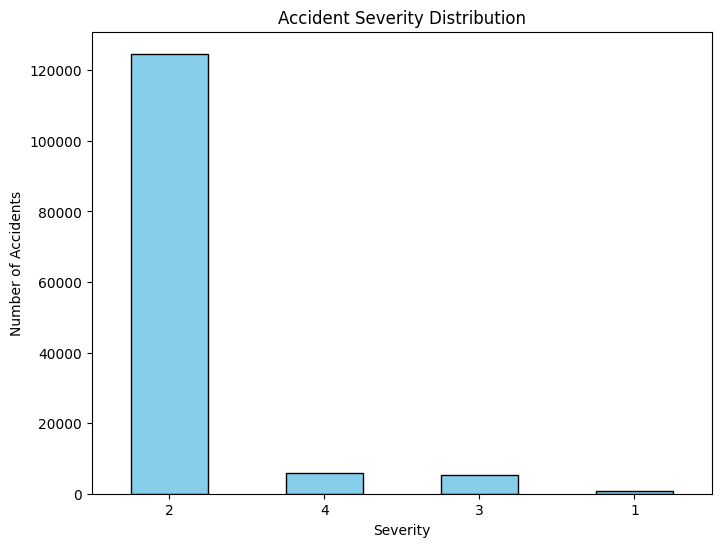

In [115]:
import matplotlib.pyplot as plt

# Plot the distribution of accident severity
plt.figure(figsize=(8,6))
source1_data_dropped_computed_cleaned['Severity'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Accident Severity Distribution')
plt.xlabel('Severity')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=0)
plt.show()


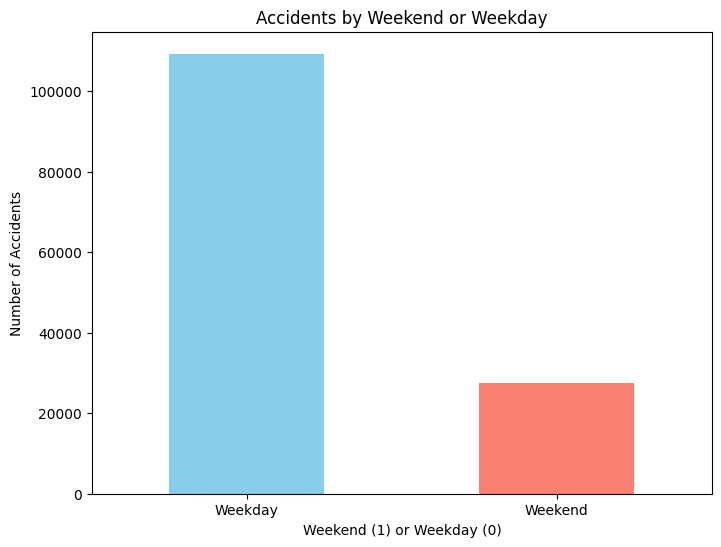

In [116]:
import matplotlib.pyplot as plt

# Plot the distribution of accidents by weekend (weekend_or_not)
plt.figure(figsize=(8,6))
source1_data_dropped_computed_cleaned['weekend_or_not'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Accidents by Weekend or Weekday')
plt.xlabel('Weekend (1) or Weekday (0)')
plt.ylabel('Number of Accidents')
plt.xticks(ticks=[0, 1], labels=['Weekday', 'Weekend'], rotation=0)
plt.show()



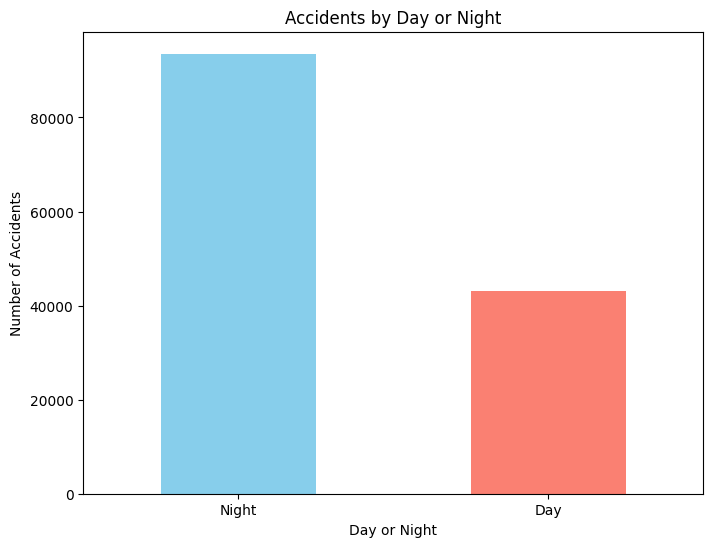

In [117]:
# Plot the distribution of accidents by day or night
plt.figure(figsize=(8,6))
source1_data_dropped_computed_cleaned['day_or_night'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Accidents by Day or Night')
plt.xlabel('Day or Night')
plt.ylabel('Number of Accidents')
plt.xticks(ticks=[0, 1], labels=['Night', 'Day'], rotation=0)
plt.show()


<Figure size 1000x600 with 0 Axes>

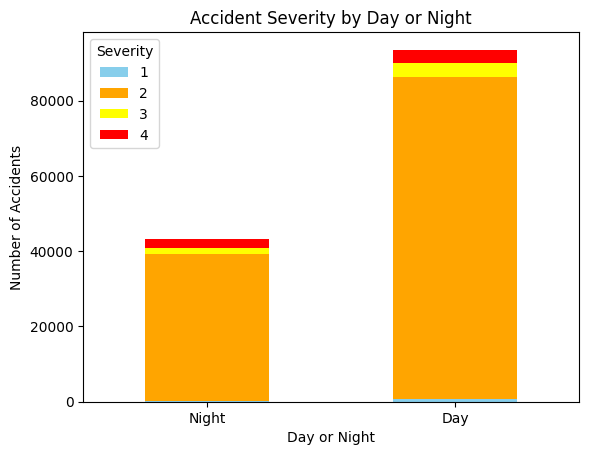

In [118]:
# Plot the distribution of accident severity based on day or night
plt.figure(figsize=(10,6))
source1_data_dropped_computed_cleaned.groupby('day_or_night')['Severity'].value_counts().unstack().plot(kind='bar', stacked=True, color=['skyblue', 'orange', 'yellow', 'red'])
plt.title('Accident Severity by Day or Night')
plt.xlabel('Day or Night')
plt.ylabel('Number of Accidents')
plt.xticks(ticks=[0, 1], labels=['Night', 'Day'], rotation=0)
plt.legend(title="Severity", labels=["1", "2", "3", "4"])
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_3640\2544497368.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source1_data_dropped_computed_cleaned['Hour'] = source1_data_dropped_computed_cleaned['Weather_Timestamp'].dt.hour


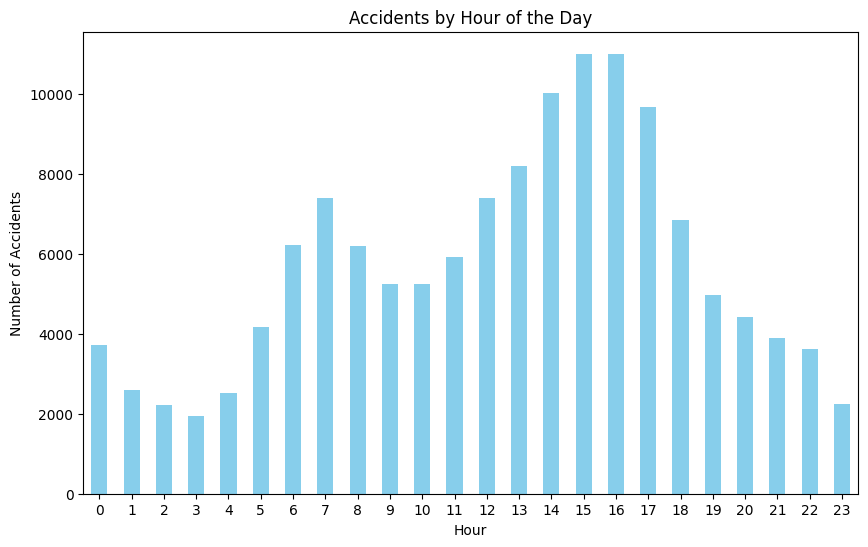

In [119]:
import matplotlib.pyplot as plt

# Extract hour from Start_Time
source1_data_dropped_computed_cleaned['Hour'] = source1_data_dropped_computed_cleaned['Weather_Timestamp'].dt.hour

# Plot accidents by hour
plt.figure(figsize=(10,6))
source1_data_dropped_computed_cleaned.groupby('Hour').size().plot(kind='bar', color='skyblue')
plt.title('Accidents by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=0)
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_3640\2027968020.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source1_data_dropped_computed_cleaned['DayOfWeek'] = source1_data_dropped_computed_cleaned['Weather_Timestamp'].dt.dayofweek


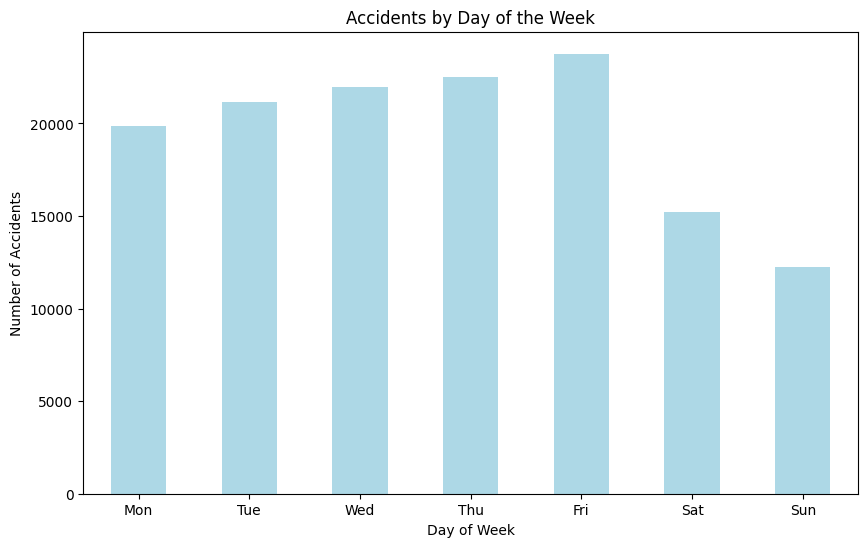

In [120]:
# Extract day of the week from Start_Time
source1_data_dropped_computed_cleaned['DayOfWeek'] = source1_data_dropped_computed_cleaned['Weather_Timestamp'].dt.dayofweek

# Plot accidents by day of the week
plt.figure(figsize=(10,6))
source1_data_dropped_computed_cleaned.groupby('DayOfWeek').size().plot(kind='bar', color='lightblue')
plt.title('Accidents by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Accidents')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_3640\242595000.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source1_data_dropped_computed_cleaned['Month'] = source1_data_dropped_computed_cleaned['Weather_Timestamp'].dt.month


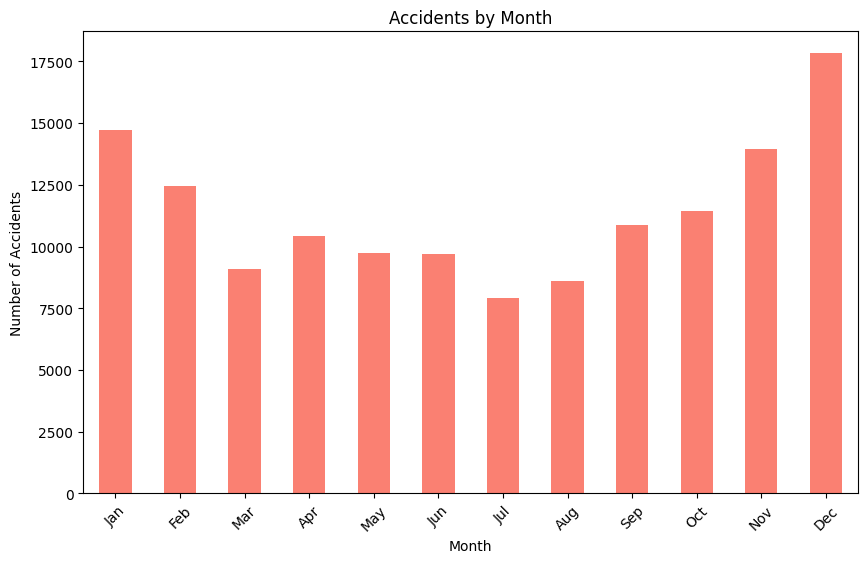

In [121]:
# Extract month from Start_Time
source1_data_dropped_computed_cleaned['Month'] = source1_data_dropped_computed_cleaned['Weather_Timestamp'].dt.month

# Plot accidents by month
plt.figure(figsize=(10,6))
source1_data_dropped_computed_cleaned.groupby('Month').size().plot(kind='bar', color='salmon')
plt.title('Accidents by Month')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.xticks(ticks=range(0,12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()


<Figure size 1000x600 with 0 Axes>

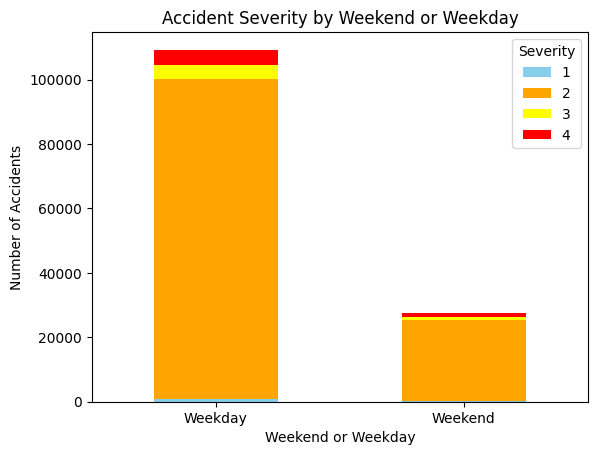

In [122]:
# Plot accidents by weekend/weekday with severity distribution
plt.figure(figsize=(10,6))
source1_data_dropped_computed_cleaned.groupby('weekend_or_not')['Severity'].value_counts().unstack().plot(kind='bar', stacked=True, color=['skyblue', 'orange', 'yellow', 'red'])
plt.title('Accident Severity by Weekend or Weekday')
plt.xlabel('Weekend or Weekday')
plt.ylabel('Number of Accidents')
plt.xticks(ticks=[0, 1], labels=['Weekday', 'Weekend'], rotation=0)
plt.legend(title="Severity", labels=["1", "2", "3", "4"])
plt.show()


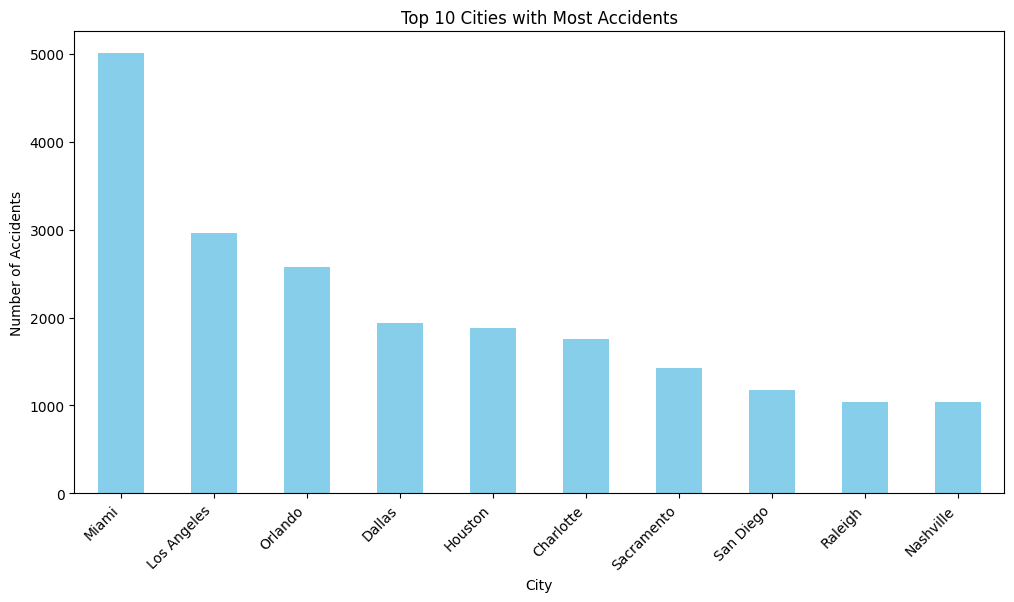

In [123]:
# Top 10 cities with the most accidents
top_cities = source1_data_dropped_computed_cleaned['City'].value_counts().head(10)
plt.figure(figsize=(12,6))
top_cities.plot(kind='bar', color='skyblue')
plt.title('Top 10 Cities with Most Accidents')
plt.xlabel('City')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.show()


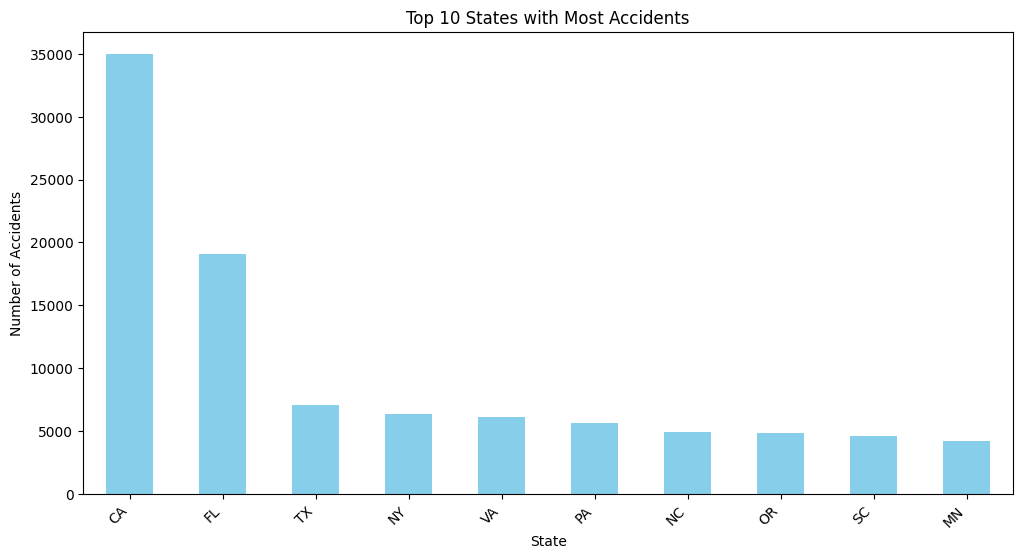

In [124]:
# Top 10 states with the most accidents
top_states = source1_data_dropped_computed_cleaned['State'].value_counts().head(10)
plt.figure(figsize=(12,6))
top_states.plot(kind='bar', color='skyblue')
plt.title('Top 10 States with Most Accidents')
plt.xlabel('State')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.show()


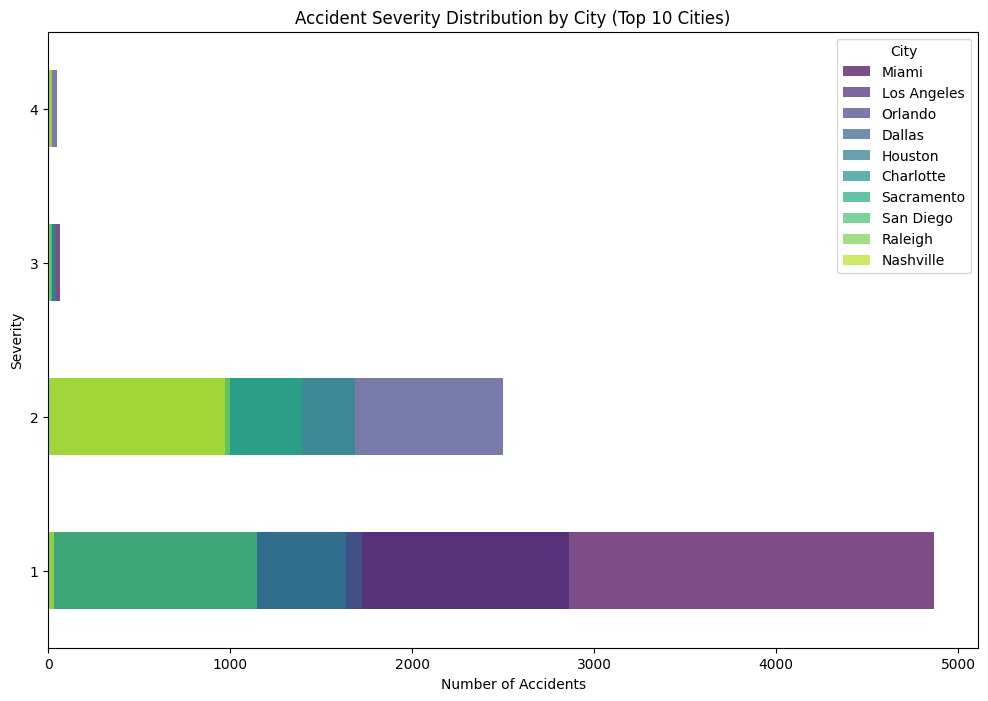

In [125]:
# Top 10 cities with the most accidents
top_cities = source1_data_dropped_computed_cleaned['City'].value_counts().head(10)

# Plot accident severity by city for the top 10 cities (swapping x and y axes)
plt.figure(figsize=(12,8))
for city in top_cities.index:
    city_data = source1_data_dropped_computed_cleaned[source1_data_dropped_computed_cleaned['City'] == city]
    city_data.groupby('Severity').size().plot(
        kind='barh', 
        label=city, 
        alpha=0.7, 
        color=plt.cm.viridis(top_cities.index.get_loc(city) / len(top_cities))
    )

plt.title('Accident Severity Distribution by City (Top 10 Cities)')
plt.xlabel('Number of Accidents')
plt.ylabel('Severity')
plt.legend(title="City", loc='upper right')
plt.show()

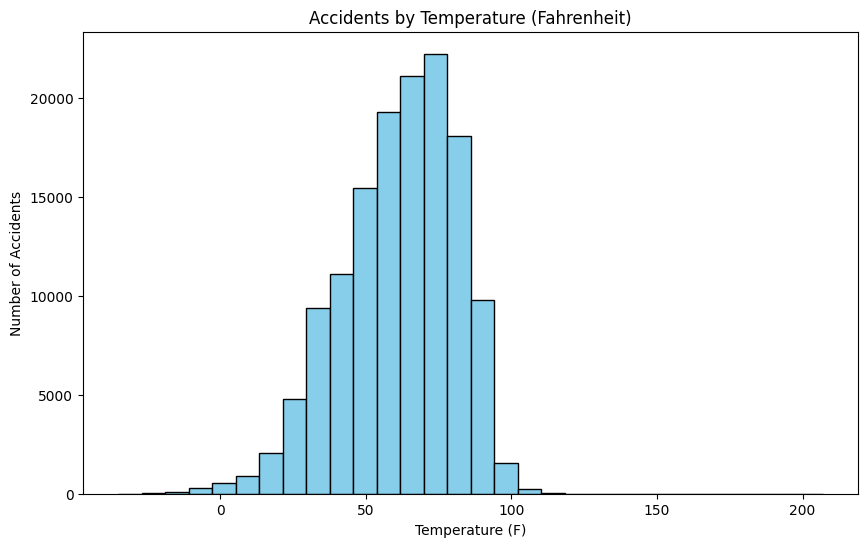

In [126]:
# Plot accidents by temperature (categorized by ranges)
plt.figure(figsize=(10,6))
source1_data_dropped_computed_cleaned['Temperature(F)'].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
plt.title('Accidents by Temperature (Fahrenheit)')
plt.xlabel('Temperature (F)')
plt.ylabel('Number of Accidents')
plt.show()


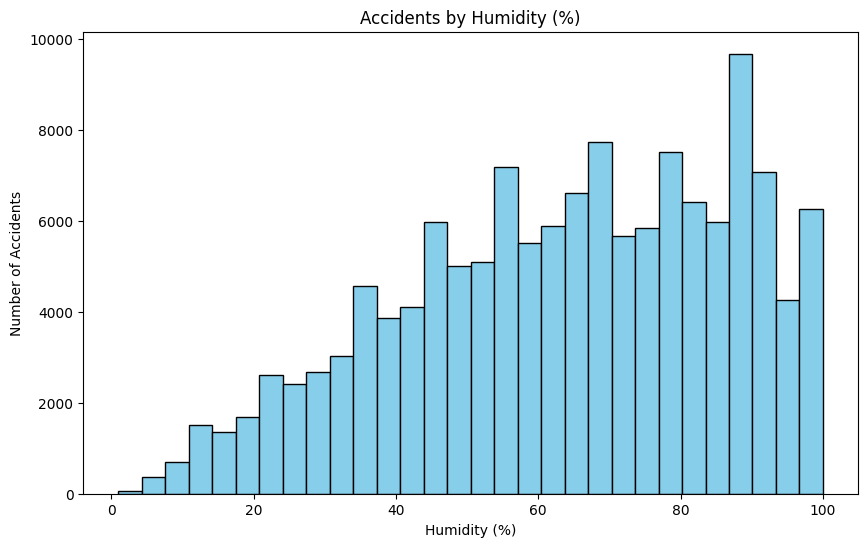

In [127]:
# Plot accidents by humidity percentage
plt.figure(figsize=(10,6))
source1_data_dropped_computed_cleaned['Humidity(%)'].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
plt.title('Accidents by Humidity (%)')
plt.xlabel('Humidity (%)')
plt.ylabel('Number of Accidents')
plt.show()


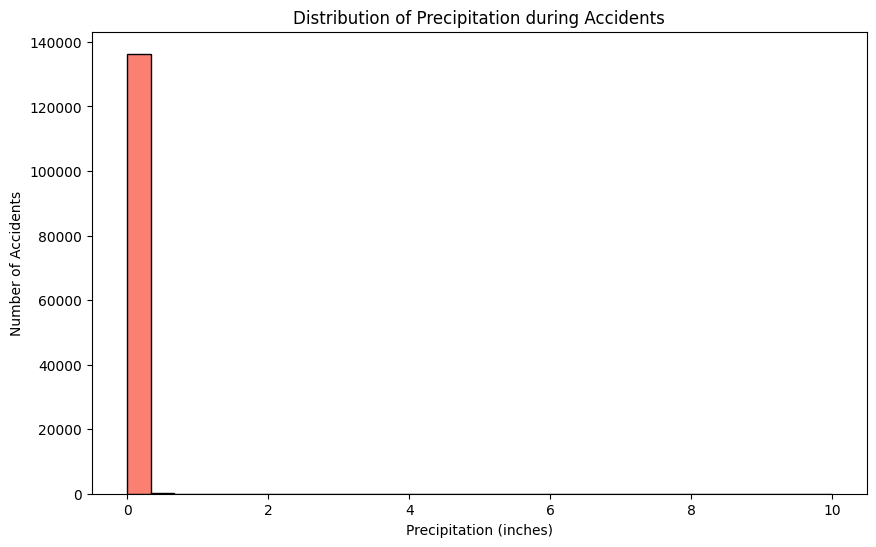

In [128]:
# Plotting precipitation distribution
plt.figure(figsize=(10,6))
source1_data_dropped_computed_cleaned['Precipitation(in)'].plot(kind='hist', bins=30, color='salmon', edgecolor='black')
plt.title('Distribution of Precipitation during Accidents')
plt.xlabel('Precipitation (inches)')
plt.ylabel('Number of Accidents')
plt.show()

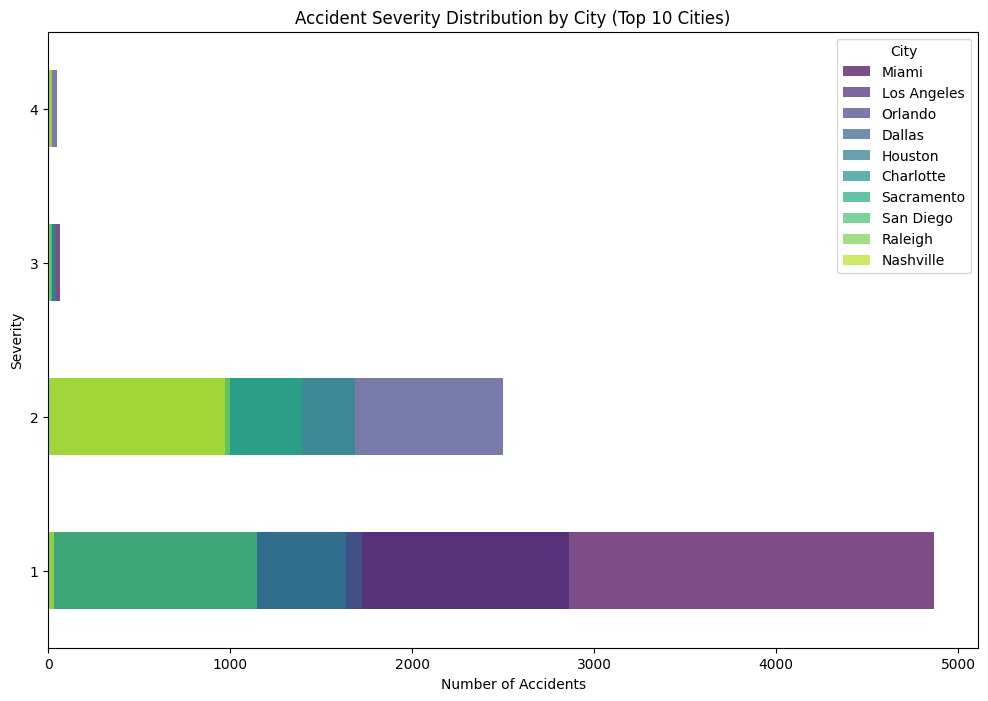

In [129]:
# Top 10 cities with the most accidents
top_cities = source1_data_dropped_computed_cleaned['City'].value_counts().head(10)

# Plot accident severity by city for the top 10 cities (swapping x and y axes)
plt.figure(figsize=(12,8))
for city in top_cities.index:
    city_data = source1_data_dropped_computed_cleaned[source1_data_dropped_computed_cleaned['City'] == city]
    city_data.groupby('Severity').size().plot(
        kind='barh', 
        label=city, 
        alpha=0.7, 
        color=plt.cm.viridis(top_cities.index.get_loc(city) / len(top_cities))
    )

plt.title('Accident Severity Distribution by City (Top 10 Cities)')
plt.xlabel('Number of Accidents')
plt.ylabel('Severity')
plt.legend(title="City", loc='upper right')
plt.show()

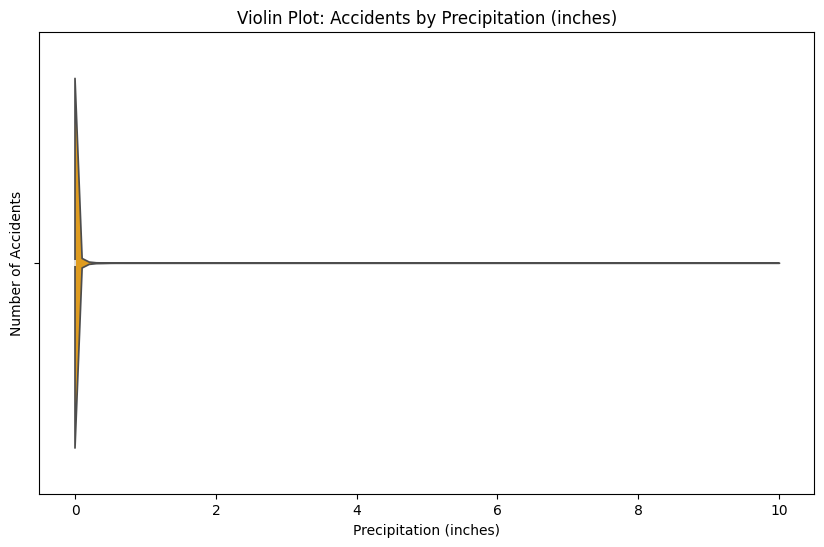

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns

# Violin plot for accidents by precipitation (in inches)
plt.figure(figsize=(10, 6))
sns.violinplot(x=source1_data_dropped_computed_cleaned['Precipitation(in)'], color='orange')
plt.title('Violin Plot: Accidents by Precipitation (inches)')
plt.xlabel('Precipitation (inches)')
plt.ylabel('Number of Accidents')
plt.show()


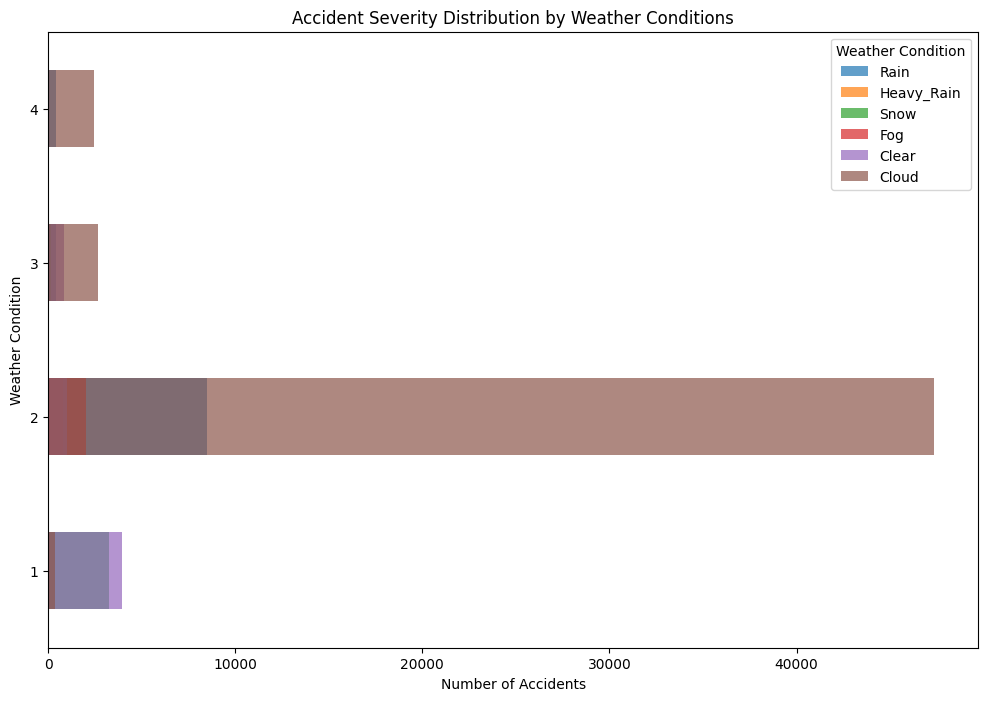

In [131]:
# Plot accident severity distribution based on weather conditions (like rain, snow, fog, etc.) with swapped axes
weather_conditions = ['Rain', 'Heavy_Rain', 'Snow', 'Fog', 'Clear', 'Cloud']

plt.figure(figsize=(12,8))
for condition in weather_conditions:
    data = source1_data_dropped_computed_cleaned[source1_data_dropped_computed_cleaned[condition] == True]
    data.groupby('Severity').size().plot(kind='barh', label=condition, alpha=0.7, color=plt.cm.tab10(weather_conditions.index(condition) % 10))

plt.title('Accident Severity Distribution by Weather Conditions')
plt.xlabel('Number of Accidents')
plt.ylabel('Weather Condition')
plt.legend(title="Weather Condition")
plt.show()




C:\Users\ASUS\AppData\Local\Temp\ipykernel_3640\572363458.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source1_data_dropped_computed_cleaned['Temperature(F)_range'] = pd.cut(source1_data_dropped_computed_cleaned['Temperature(F)'], bins=[-10, 0, 32, 50, 70, 90, 120], labels=['<0', '0-32', '33-50', '51-70', '71-90', '90+'])


<Figure size 1000x600 with 0 Axes>

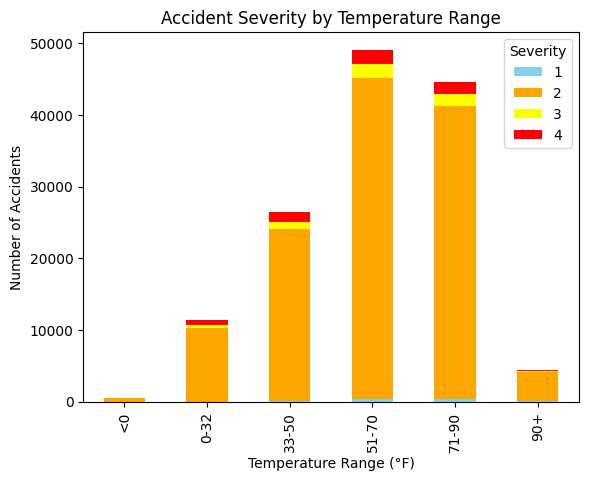

In [132]:
# Plot accident severity by temperature ranges
plt.figure(figsize=(10,6))
source1_data_dropped_computed_cleaned['Temperature(F)_range'] = pd.cut(source1_data_dropped_computed_cleaned['Temperature(F)'], bins=[-10, 0, 32, 50, 70, 90, 120], labels=['<0', '0-32', '33-50', '51-70', '71-90', '90+'])
source1_data_dropped_computed_cleaned.groupby('Temperature(F)_range')['Severity'].value_counts().unstack().plot(kind='bar', stacked=True, color=['skyblue', 'orange', 'yellow', 'red'])
plt.title('Accident Severity by Temperature Range')
plt.xlabel('Temperature Range (°F)')
plt.ylabel('Number of Accidents')
plt.legend(title="Severity", labels=["1", "2", "3", "4"])
plt.show()


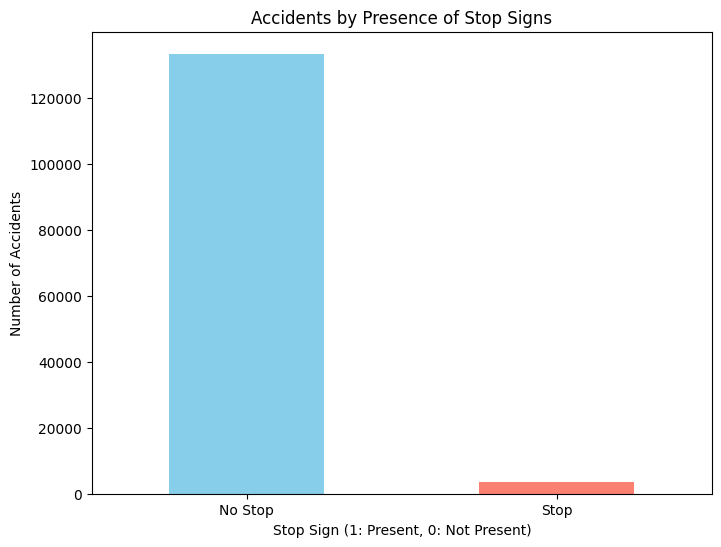

In [133]:
# Plot accidents by presence of stop signs
plt.figure(figsize=(8,6))
source1_data_dropped_computed_cleaned['Stop'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Accidents by Presence of Stop Signs')
plt.xlabel('Stop Sign (1: Present, 0: Not Present)')
plt.ylabel('Number of Accidents')
plt.xticks(ticks=[0, 1], labels=['No Stop', 'Stop'], rotation=0)
plt.show()


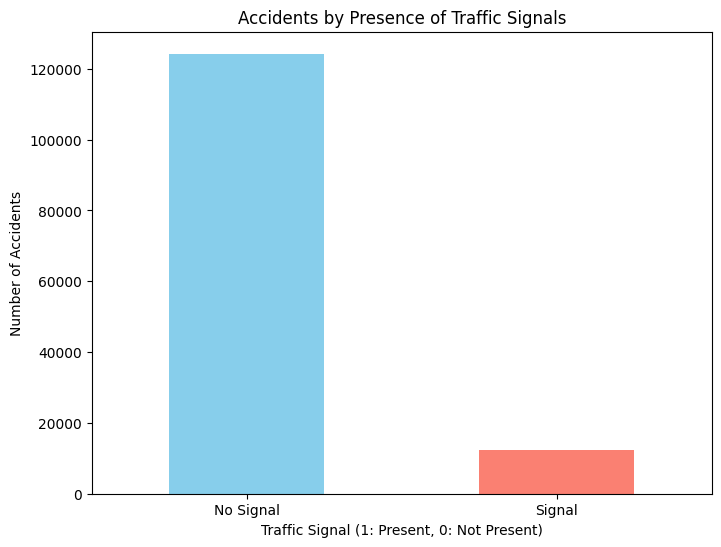

In [134]:
# Plot accidents by presence of traffic signals
plt.figure(figsize=(8,6))
source1_data_dropped_computed_cleaned['Traffic_Signal'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Accidents by Presence of Traffic Signals')
plt.xlabel('Traffic Signal (1: Present, 0: Not Present)')
plt.ylabel('Number of Accidents')
plt.xticks(ticks=[0, 1], labels=['No Signal', 'Signal'], rotation=0)
plt.show()


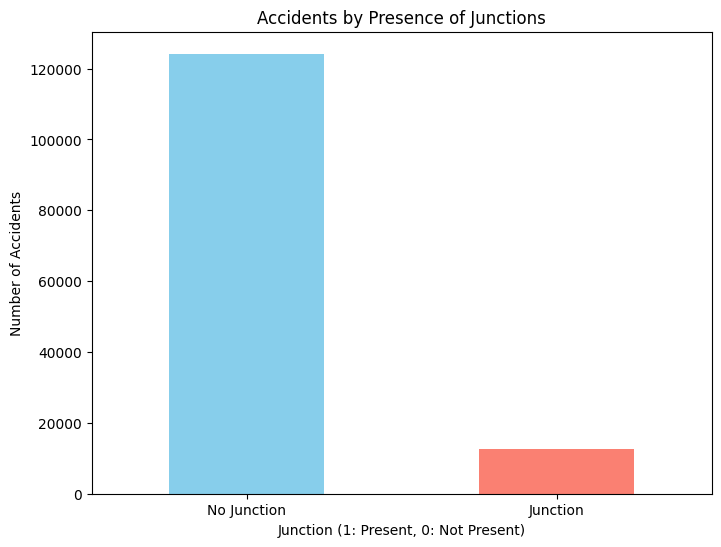

In [135]:
# Plot accidents by presence of junctions
plt.figure(figsize=(8,6))
source1_data_dropped_computed_cleaned['Junction'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Accidents by Presence of Junctions')
plt.xlabel('Junction (1: Present, 0: Not Present)')
plt.ylabel('Number of Accidents')
plt.xticks(ticks=[0, 1], labels=['No Junction', 'Junction'], rotation=0)
plt.show()


<Figure size 800x600 with 0 Axes>

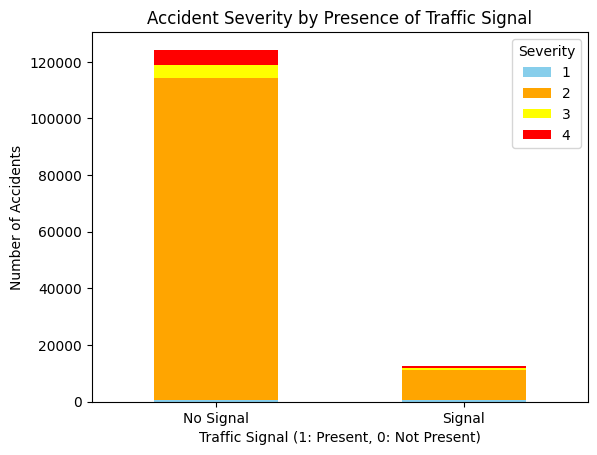

In [136]:
# Plot accidents with traffic signal vs severity
plt.figure(figsize=(8,6))
source1_data_dropped_computed_cleaned.groupby('Traffic_Signal')['Severity'].value_counts().unstack().plot(kind='bar', stacked=True, color=['skyblue', 'orange', 'yellow', 'red'])
plt.title('Accident Severity by Presence of Traffic Signal')
plt.xlabel('Traffic Signal (1: Present, 0: Not Present)')
plt.ylabel('Number of Accidents')
plt.xticks(ticks=[0, 1], labels=['No Signal', 'Signal'], rotation=0)
plt.legend(title="Severity", labels=["1", "2", "3", "4"])
plt.show()


<Figure size 800x600 with 0 Axes>

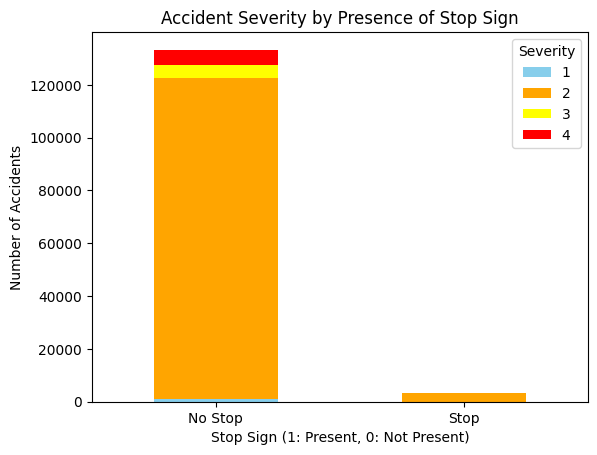

In [137]:
# Plot accidents with stop sign vs severity
plt.figure(figsize=(8,6))
source1_data_dropped_computed_cleaned.groupby('Stop')['Severity'].value_counts().unstack().plot(kind='bar', stacked=True, color=['skyblue', 'orange', 'yellow', 'red'])
plt.title('Accident Severity by Presence of Stop Sign')
plt.xlabel('Stop Sign (1: Present, 0: Not Present)')
plt.ylabel('Number of Accidents')
plt.xticks(ticks=[0, 1], labels=['No Stop', 'Stop'], rotation=0)
plt.legend(title="Severity", labels=["1", "2", "3", "4"])
plt.show()


<Figure size 800x600 with 0 Axes>

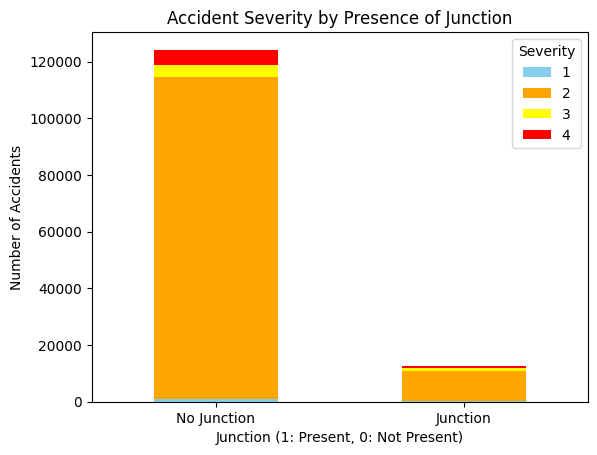

In [138]:
# Plot accidents with junction vs severity
plt.figure(figsize=(8,6))
source1_data_dropped_computed_cleaned.groupby('Junction')['Severity'].value_counts().unstack().plot(kind='bar', stacked=True, color=['skyblue', 'orange', 'yellow', 'red'])
plt.title('Accident Severity by Presence of Junction')
plt.xlabel('Junction (1: Present, 0: Not Present)')
plt.ylabel('Number of Accidents')
plt.xticks(ticks=[0, 1], labels=['No Junction', 'Junction'], rotation=0)
plt.legend(title="Severity", labels=["1", "2", "3", "4"])
plt.show()


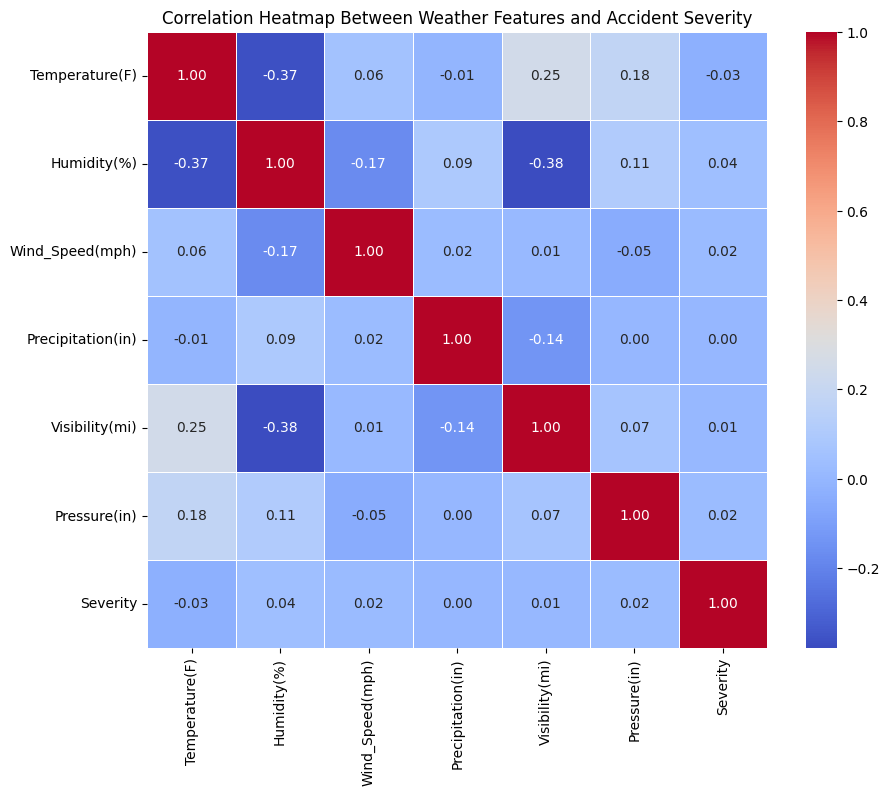

In [139]:
# Calculate correlation between weather features and severity
weather_columns = ['Temperature(F)', 'Humidity(%)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Visibility(mi)', 'Pressure(in)']
corr_matrix = source1_data_dropped_computed_cleaned[weather_columns + ['Severity']].corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap Between Weather Features and Accident Severity')
plt.show()


In [140]:
# Check the data types
print(source1_data_dropped_computed_cleaned.dtypes)

Severity                            int8
Start_Lat                        float64
Start_Lng                        float64
Street                   string[pyarrow]
City                     string[pyarrow]
County                   string[pyarrow]
State                    string[pyarrow]
Zipcode                  string[pyarrow]
Timezone                 string[pyarrow]
Airport_Code             string[pyarrow]
Weather_Timestamp         datetime64[ns]
Temperature(F)                   float32
Humidity(%)                      float32
Pressure(in)                     float64
Visibility(mi)                   float64
Wind_Direction           string[pyarrow]
Wind_Speed(mph)                  float32
Precipitation(in)                float32
Amenity                             bool
Bump                                bool
Crossing                            bool
Give_Way                            bool
Junction                            bool
No_Exit                             bool
Railway         

In [141]:
# List of columns to drop
columns_to_drop = [
    'Start_Lat', 'Start_Lng', 'Street',
    'County', 'City', 'Zipcode', 'Timezone',
    'Airport_Code', 'Weather_Timestamp',
    'Year', 'Month', 'Day', 'Weekday',
    'Hour', 'Minute', 'DayOfWeek', 'Temperature(F)_range', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'
]

# Drop the specified columns from the DataFrame
source1_data_dropped_computed_cleaned = source1_data_dropped_computed_cleaned.drop(columns=columns_to_drop)

# Verify that the columns have been dropped
source1_data_dropped_computed_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Index: 136709 entries, 0 to 166673
Data columns (total 30 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Severity           136709 non-null  int8   
 1   State              136709 non-null  string 
 2   Temperature(F)     136709 non-null  float32
 3   Humidity(%)        136709 non-null  float32
 4   Pressure(in)       136709 non-null  float64
 5   Visibility(mi)     136709 non-null  float64
 6   Wind_Direction     136709 non-null  string 
 7   Wind_Speed(mph)    136709 non-null  float32
 8   Precipitation(in)  136709 non-null  float32
 9   Amenity            136709 non-null  bool   
 10  Bump               136709 non-null  bool   
 11  Crossing           136709 non-null  bool   
 12  Give_Way           136709 non-null  bool   
 13  Junction           136709 non-null  bool   
 14  No_Exit            136709 non-null  bool   
 15  Railway            136709 non-null  bool   
 16  Roundab

In [142]:
source1_data_dropped_computed_cleaned.head()

,Severity,State,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Amenity,...,Traffic_Signal,Clear,Cloud,Rain,Heavy_Rain,Snow,Heavy_Snow,Fog,weekend_or_not,day_or_night
0,2,OR,38.0,57.0,25.94,10.0,E,12.0,0.0,False,...,False,False,False,False,False,False,False,False,False,True
1,2,MD,43.0,58.0,29.45,10.0,W,8.0,0.0,False,...,False,False,True,False,False,False,False,False,False,True
1,2,VA,45.0,48.0,29.91,10.0,W,5.0,0.0,False,...,False,False,False,False,False,False,False,False,True,False
2,2,CA,68.0,73.0,29.79,10.0,W,13.0,0.0,False,...,True,False,False,False,False,False,False,False,True,True
3,2,MN,27.0,86.0,28.49,10.0,E,15.0,0.0,False,...,False,False,False,False,False,False,False,False,False,True


In [143]:
# List of boolean columns in the dataset
bool_columns = source1_data_dropped_computed_cleaned.select_dtypes(include=['bool']).columns

# Convert the boolean columns to 0 (False) and 1 (True)
source1_data_dropped_computed_cleaned[bool_columns] = source1_data_dropped_computed_cleaned[bool_columns].astype(int)

# Verify the changes by checking the data types and the first few rows
print(source1_data_dropped_computed_cleaned[bool_columns].head())
print(source1_data_dropped_computed_cleaned.info())


   Amenity  Bump  Crossing  Give_Way  Junction  No_Exit  Railway  Roundabout  \
0        0     0         0         0         0        0        0           0   
1        0     0         0         0         0        0        0           0   
1        0     0         0         0         0        0        0           0   
2        0     0         0         0         0        0        0           0   
3        0     0         0         0         0        0        0           0   

   Station  Stop  ...  Traffic_Signal  Clear  Cloud  Rain  Heavy_Rain  Snow  \
0        0     0  ...               0      0      0     0           0     0   
1        0     0  ...               0      0      1     0           0     0   
1        0     0  ...               0      0      0     0           0     0   
2        0     0  ...               1      0      0     0           0     0   
3        0     0  ...               0      0      0     0           0     0   

   Heavy_Snow  Fog  weekend_or_not  day_or_n

In [144]:
# Get unique values for 'State' and 'Wind_Direction' columns
city_unique_values = source1_data_dropped_computed_cleaned['State'].unique()
wind_direction_unique_values = source1_data_dropped_computed_cleaned['Wind_Direction'].unique()

# Display the unique values
print("Unique values in 'State':", city_unique_values)
print("Unique values in 'Wind_Direction':", wind_direction_unique_values)


Unique values in 'State': <ArrowStringArray>
['OR', 'MD', 'VA', 'CA', 'MN', 'AZ', 'FL', 'TX', 'WA', 'NC', 'NY', 'SC', 'LA',
 'GA', 'IL', 'MO', 'WI', 'MI', 'NV', 'DE', 'TN', 'PA', 'NJ', 'CT', 'MT', 'MS',
 'IN', 'UT', 'AL', 'IA', 'WV', 'CO', 'DC', 'NE', 'OH', 'NM', 'KS', 'MA', 'AR',
 'WY', 'KY', 'RI', 'ID', 'NH', 'OK', 'ND', 'ME', 'VT', 'SD']
Length: 49, dtype: string
Unique values in 'Wind_Direction': <ArrowStringArray>
['E', 'W', 'VAR', 'N', 'S', 'NW', 'SE', 'CALM', 'NE', 'SW']
Length: 10, dtype: string


In [145]:
# Create a dictionary for encoding 'State' (0-48)
state_mapping = {state: idx for idx, state in enumerate(source1_data_dropped_computed_cleaned['State'].unique())}

# Create a dictionary for encoding 'Wind_Direction' (0-9)
wind_direction_mapping = {direction: idx for idx, direction in enumerate(source1_data_dropped_computed_cleaned['Wind_Direction'].unique())}

# Apply the mappings to encode the columns
source1_data_dropped_computed_cleaned['State'] = source1_data_dropped_computed_cleaned['State'].map(state_mapping)
source1_data_dropped_computed_cleaned['Wind_Direction'] = source1_data_dropped_computed_cleaned['Wind_Direction'].map(wind_direction_mapping)

# Verify the changes
print("Encoded 'State' values:", source1_data_dropped_computed_cleaned['State'].unique())
print("Encoded 'Wind_Direction' values:", source1_data_dropped_computed_cleaned['Wind_Direction'].unique())


Encoded 'State' values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48]
Encoded 'Wind_Direction' values: [0 1 2 3 4 5 6 7 8 9]


In [146]:
# Verify that the columns have been dropped
source1_data_dropped_computed_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136709 entries, 0 to 166673
Data columns (total 30 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Severity           136709 non-null  int8   
 1   State              136709 non-null  int64  
 2   Temperature(F)     136709 non-null  float32
 3   Humidity(%)        136709 non-null  float32
 4   Pressure(in)       136709 non-null  float64
 5   Visibility(mi)     136709 non-null  float64
 6   Wind_Direction     136709 non-null  int64  
 7   Wind_Speed(mph)    136709 non-null  float32
 8   Precipitation(in)  136709 non-null  float32
 9   Amenity            136709 non-null  int32  
 10  Bump               136709 non-null  int32  
 11  Crossing           136709 non-null  int32  
 12  Give_Way           136709 non-null  int32  
 13  Junction           136709 non-null  int32  
 14  No_Exit            136709 non-null  int32  
 15  Railway            136709 non-null  int32  
 16  Roundab

# Model Building and Evaluation

In [147]:
# Get value counts for the 'Severity' column
severity_counts = source1_data_dropped_computed_cleaned['Severity'].value_counts()

# Print the value counts
print(severity_counts)


Severity
2    124698
4      5887
3      5235
1       889
Name: count, dtype: int64


In [148]:
# Import necessary libraries
from imblearn.over_sampling import SMOTE
from collections import Counter

# Separate features and target
X = source1_data_dropped_computed_cleaned.drop('Severity', axis=1)  # Features
y = source1_data_dropped_computed_cleaned['Severity']  # Target

# Initialize SMOTE with default parameters
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to oversample the minority class
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the new class distribution
print("Original class distribution:", Counter(y))
print("Resampled class distribution:", Counter(y_resampled))

# Optionally, convert back to DataFrame if needed
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled_df = pd.DataFrame(y_resampled, columns=['Severity'])

# Combine X and y into a final resampled dataset
resampled_data = pd.concat([X_resampled_df, y_resampled_df], axis=1)

# Show the first few rows of the resampled dataset
print(resampled_data.head())


Original class distribution: Counter({2: 124698, 4: 5887, 3: 5235, 1: 889})
Resampled class distribution: Counter({2: 124698, 4: 124698, 1: 124698, 3: 124698})
   State  Temperature(F)  Humidity(%)  Pressure(in)  Visibility(mi)  \
0      0            38.0         57.0         25.94            10.0   
1      1            43.0         58.0         29.45            10.0   
2      2            45.0         48.0         29.91            10.0   
3      3            68.0         73.0         29.79            10.0   
4      4            27.0         86.0         28.49            10.0   

   Wind_Direction  Wind_Speed(mph)  Precipitation(in)  Amenity  Bump  ...  \
0               0             12.0                0.0        0     0  ...   
1               1              8.0                0.0        0     0  ...   
2               1              5.0                0.0        0     0  ...   
3               1             13.0                0.0        0     0  ...   
4               0           

In [149]:
# Import necessary libraries
from imblearn.over_sampling import SMOTE
from collections import Counter

# Separate features and target
X = source1_data_dropped_computed_cleaned.drop('Severity', axis=1)  # Features
y = source1_data_dropped_computed_cleaned['Severity']  # Target

# Initialize SMOTE with default parameters
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to oversample the minority class
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the new class distribution
print("Original class distribution:", Counter(y))
print("Resampled class distribution:", Counter(y_resampled))

# Optionally, convert back to DataFrame if needed
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled_df = pd.DataFrame(y_resampled, columns=['Severity'])

# Combine X and y into a final resampled dataset
resampled_data = pd.concat([X_resampled_df, y_resampled_df], axis=1)

# Show the first few rows of the resampled dataset
print(resampled_data.head())


Original class distribution: Counter({2: 124698, 4: 5887, 3: 5235, 1: 889})
Resampled class distribution: Counter({2: 124698, 4: 124698, 1: 124698, 3: 124698})
   State  Temperature(F)  Humidity(%)  Pressure(in)  Visibility(mi)  \
0      0            38.0         57.0         25.94            10.0   
1      1            43.0         58.0         29.45            10.0   
2      2            45.0         48.0         29.91            10.0   
3      3            68.0         73.0         29.79            10.0   
4      4            27.0         86.0         28.49            10.0   

   Wind_Direction  Wind_Speed(mph)  Precipitation(in)  Amenity  Bump  ...  \
0               0             12.0                0.0        0     0  ...   
1               1              8.0                0.0        0     0  ...   
2               1              5.0                0.0        0     0  ...   
3               1             13.0                0.0        0     0  ...   
4               0           

In [150]:
# Import necessary library
from sklearn.model_selection import train_test_split

# Split the resampled data into features (X) and target (y)
X_resampled_df = resampled_data.drop('Severity', axis=1)  # Features
y_resampled_df = resampled_data['Severity']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_df, y_resampled_df, test_size=0.2, random_state=42)

# Check the shapes of the resulting datasets
print("Training set features shape:", X_train.shape)
print("Testing set features shape:", X_test.shape)
print("Training set target shape:", y_train.shape)
print("Testing set target shape:", y_test.shape)


Training set features shape: (399033, 29)
Testing set features shape: (99759, 29)
Training set target shape: (399033,)
Testing set target shape: (99759,)


In [151]:
# Import Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Confusion Matrix for Random Forest
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Classification Report for Random Forest
print("\nClassification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))


Random Forest Confusion Matrix:
[[24815    87     9     4]
 [  159 22659   890  1162]
 [   44   652 23839   301]
 [   35   928   313 23862]]

Classification Report for Random Forest:
              precision    recall  f1-score   support

           1       0.99      1.00      0.99     24915
           2       0.93      0.91      0.92     24870
           3       0.95      0.96      0.96     24836
           4       0.94      0.95      0.95     25138

    accuracy                           0.95     99759
   macro avg       0.95      0.95      0.95     99759
weighted avg       0.95      0.95      0.95     99759



In [152]:
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Initialize Logistic Regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the Logistic Regression model
lr_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test)

# Confusion Matrix for Logistic Regression
print("\nLogistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

# Classification Report for Logistic Regression
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_lr))



Logistic Regression Confusion Matrix:
[[12957  3686  3545  4727]
 [ 4532 12998  3790  3550]
 [ 3655  4550  7840  8791]
 [ 3436  3819  5180 12703]]

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           1       0.53      0.52      0.52     24915
           2       0.52      0.52      0.52     24870
           3       0.39      0.32      0.35     24836
           4       0.43      0.51      0.46     25138

    accuracy                           0.47     99759
   macro avg       0.46      0.47      0.46     99759
weighted avg       0.46      0.47      0.46     99759



c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
